# Deep Learning Summarizer

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from datasets import load_dataset
from attention import AttentionLayer
import re
import contractions
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import tensorflow.keras.backend as K
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [3]:
dataset = load_dataset("ccdv/arxiv-summarization", cache_dir="./data/")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract'],
        num_rows: 203037
    })
    validation: Dataset({
        features: ['article', 'abstract'],
        num_rows: 6436
    })
    test: Dataset({
        features: ['article', 'abstract'],
        num_rows: 6440
    })
})


In [4]:
train_df = pd.DataFrame(dataset["train"])
validation_df = pd.DataFrame(dataset["validation"])
test_df = pd.DataFrame(dataset["test"])

print(train_df.shape[0])
print(validation_df.shape[0])
print(test_df.shape[0])

In [ ]:
df = pd.concat([train_df, validation_df, test_df], keys=['train', 'validation', 'test'], ignore_index=False)

In [ ]:
df['article'].head(10)

train  0    additive models @xcite provide an important family of models for semiparametric regression or classification . some reasons for the success of additive models are their increased flexibility when ...
       1    the leptonic decays of a charged pseudoscalar meson @xmath7 are processes of the type @xmath8 , where @xmath9 , @xmath10 , or @xmath11 . because no strong interactions are present in the leptonic ...
       2    the transport properties of nonlinear non - equilibrium dynamical systems are far from well - understood@xcite . \n consider in particular so - called ratchet systems which are asymmetric periodic...
       3    studies of laser beams propagating through turbulent atmospheres are important for many applications such as remote sensing , tracking , and long - distance optical communications . \n howerver , ...
       4    the so - called `` nucleon spin crisis '' raised by the european muon collaboration ( emc ) measurement in 1988 is one of the most outstandi

In [ ]:
df['abstract'].head(10)

train  0    additive models play an important role in semiparametric statistics . \n this paper gives learning rates for regularized kernel based methods for additive models . \n these learning rates compare ...
       1    we have studied the leptonic decay @xmath0 , via the decay channel @xmath1 , using a sample of tagged @xmath2 decays collected near the @xmath3 peak production energy in @xmath4 collisions with th...
       2    in 84 , 258 ( 2000 ) , mateos conjectured that current reversal in a classical deterministic ratchet is associated with bifurcations from chaotic to periodic regimes . \n this is based on the comp...
       3    the effect of a random phase diffuser on fluctuations of laser light ( scintillations ) is studied . \n not only spatial but also temporal phase variations introduced by the phase diffuser are ana...
       4    with a special intention of clarifying the underlying spin contents of the nucleon , we investigate the generalized form factors of the nucl

Things to resolve:

- Text inside parenthesis
- Text inside brackets
- Text inside curly brackets
- Words of length less than 1
- Text with symbols i.e. @, $, etc. (In general all I want is english alphabet characters and possibly numbers)
- URLs i.e. www.comsol.com
- Contractions
- Stop Words
- Lower Case
- New lines (\n) and possibly tabs (\t)


In [7]:
def clean_text(text, abstract=False):
    new_text = text.lower()
    new_text = re.sub(r'\([^)]*\)|\[[^\]]*\]|\{[^}]*\}', '', new_text) # Removes text inside (), [], {}
    new_text = re.sub(r'\b(?:https?://)?(?:www\.)?\S+\.com\b', '', new_text) # Removes URLs
    new_text = re.sub(r'[\n\t]', '', new_text) # New lines and tabs
    new_text = ' '.join([contractions.fix(w) for w in new_text.split(' ')]) # Fixes contractions
    new_text = re.sub(r'[^\w\s]', ' ', new_text) # Remove non-words
    new_text = re.sub(r'\b\w*[^\w\s]+\w*\b', '', new_text) # Remove symbols from words
    new_text = re.sub(r'[^a-zA-z]', ' ', new_text) # Keeps all English alphabet characters
    stop_words = set(stopwords.words('english'))
    if not abstract:
        new_text = [w for w in new_text.split() if not w in stop_words] # Removing stop words from non abstract text
    else:
        new_text = new_text.split()
    new_text = [w for w in new_text if len(w) > 1] # Removing remaining words with only 1 character
    return (' '.join(new_text)).strip() 

In [8]:
df['cleaned_article'] = df['article'].apply(lambda x: clean_text(x))

In [9]:
df['cleaned_article'].head(10)

train  0    additive models xcite provide important family models semiparametric regression classification reasons success additive models increased flexibility compared linear generalized linear models incre...
       1    leptonic decays charged pseudoscalar meson xmath processes type xmath xmath xmath xmath strong interactions present leptonic final state xmath decays provide clean way probe complex strong interac...
       2    transport properties nonlinear non equilibrium dynamical systems far well understood xcite consider particular called ratchet systems asymmetric periodic potentials ensemble particles experience d...
       3    studies laser beams propagating turbulent atmospheres important many applications remote sensing tracking long distance optical communications howerver fully coherent laser beams sensitive fluctua...
       4    called nucleon spin crisis raised european muon collaboration measurement one outstanding findings field hadron physics xcite xcite renaissa

In [41]:
df['cleaned_abstract'] = df['abstract'].apply(lambda x: f'<SOS> {clean_text(x, abstract=True)} <EOS>')

In [45]:
df['cleaned_abstract'].head(10)

train  0    <SOS> additive models play an important role in semiparametric statistics this paper gives learning rates for regularized kernel based methods for additive models these learning rates compare favo...
       1    <SOS> we have studied the leptonic decay xmath via the decay channel xmath using sample of tagged xmath decays collected near the xmath peak production energy in xmath collisions with the cleo det...
       2    <SOS> in mateos conjectured that current reversal in classical deterministic ratchet is associated with bifurcations from chaotic to periodic regimes this is based on the comparison of the current...
       3    <SOS> the effect of random phase diffuser on fluctuations of laser light is studied not only spatial but also temporal phase variations introduced by the phase diffuser are analyzed the explicit d...
       4    <SOS> with special intention of clarifying the underlying spin contents of the nucleon we investigate the generalized form factors of the nu

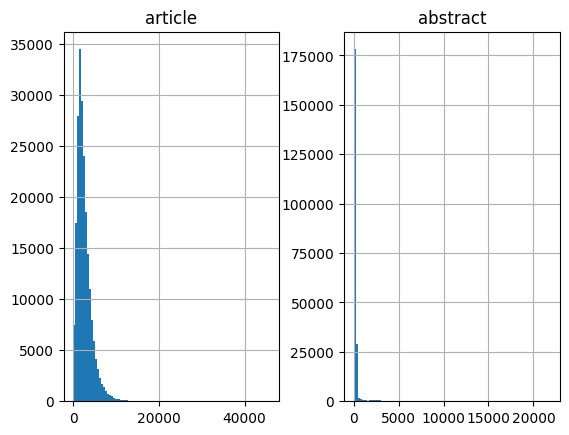

In [42]:
import matplotlib.pyplot as plt

article_word_count = []
abstract_word_count = []

for a in df['cleaned_article']:
    article_word_count.append(len(a.split(' ')))
    
for a in df['cleaned_abstract']:
    abstract_word_count.append(len(a.split(' ')))
    
count_df = pd.DataFrame({'article': article_word_count, 'abstract': abstract_word_count})
count_df.hist(bins=100)
plt.show()

In [47]:
print(f"Mean Article Word Count: {np.mean(article_word_count)}")
print(f"Median Article Word Count: {np.median(article_word_count)}")
print(f"Mean Abstract Word Count: {np.mean(abstract_word_count)}")
print(f"Median Abstract Word Count: {np.median(abstract_word_count)}")

Mean Article Word Count: 2573.1951897291965
Median Article Word Count: 2147.0
Mean Abstract Word Count: 217.60266403597745
Median Abstract Word Count: 138.0


In [48]:
train_df_cleaned, validation_df_cleaned, test_df_cleaned = df.xs('train'), df.xs('validation'), df.xs('test')

print(train_df_cleaned.shape[0])
print(validation_df_cleaned.shape[0])
print(test_df_cleaned.shape[0])

203037
6436
6440


In [61]:
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(train_df_cleaned['cleaned_article']))
X_train = X_tokenizer.texts_to_sequences(list(train_df_cleaned['cleaned_article']))
X_train = pad_sequences(X_train, maxlen=2500, padding='post')

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(train_df_cleaned['cleaned_abstract']))
y_train = y_tokenizer.texts_to_sequences(list(train_df_cleaned['cleaned_abstract']))
y_train = pad_sequences(y_train, maxlen=200, padding='post')

with open("../models/X_tokenizer.pickle", "wb") as handle:
    pickle.dump(X_tokenizer, handle)
    
with open("../models/y_tokenizer.pickle", "wb") as handle:
    pickle.dump(y_tokenizer, handle)

In [71]:
X_vocab = len(X_tokenizer.word_index) + 1
y_vocab = len(y_tokenizer.word_index) + 1

print(X_vocab)
print(y_vocab)

703833
166488


In [112]:
K.clear_session()

embed_dim = 300
latent_dim = 500

# Encoder
encoder_input = Input(shape=(2500, ))
encoder_embed = Embedding(X_vocab, embed_dim, trainable=True)(encoder_input)
encoder_bidirectional = Bidirectional(LSTM(250, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.3))
encoder_output_bi, forward_h, backward_h, forward_c, backward_c = encoder_bidirectional(encoder_embed)
state_h = Concatenate(axis=-1)([forward_h, backward_h])
state_c = Concatenate(axis=-1)([forward_c, backward_c])
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.3)
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_output_bi, initial_state=[state_h, state_c])
# encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embed)
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.3)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.3)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

# Decoder
decoder_input = Input(shape=(None, ))
decoder_embed = Embedding(y_vocab, embed_dim, trainable=True)(decoder_input)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.3)
decoder_output, _, _ = decoder_lstm(decoder_embed, initial_state=[state_h3, state_c3])

# Attention
attention = AttentionLayer()
attention_output, _ = attention([encoder_output3, decoder_output])

# Concatenate Attention with LSTM Output
concatenate = Concatenate(axis=-1)([decoder_output, attention_output])
decoder_dense = TimeDistributed(Dense(y_vocab, activation='softmax'))
decoder_output = decoder_dense(concatenate)

model = Model([encoder_input, decoder_input], decoder_output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2500)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 2500, 300) │ 211,149,9… │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 2500,     │  1,102,000 │ embedding[0][0]   │
│ (Bidirectional)     │ 500), (None,      │            │                   │
│                     │ 250), (None,      │            │                   │
│                     │ 250), (None,      │            │                   │
│                     │ 250), (None,      │            │                   │
│                     │ 250)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 500)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 500)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 2500,     │  2,002,000 │ bidirectional[0]… │
│                     │ 500), (None,      │            │ concatenate[0][0… │
│                     │ 500), (None,      │            │ concatenate_1[0]… │
│                     │ 500)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 2500,     │  2,002,000 │ lstm_1[0][0]      │
│                     │ 500), (None,      │            │                   │
│                     │ 500), (None,      │            │                   │
│                     │ 500)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 300) │ 49,946,400 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 2500,     │  2,002,000 │ lstm_2[0][0]      │
│                     │ 500), (None,      │            │                   │
│                     │ 500), (None,      │            │                   │
│                     │ 500)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, None,     │  1,602,000 │ embedding_1[0][0… │
│                     │ 500), (None,      │            │ lstm_3[0][1],     │
│                     │ 500), (None,      │            │ lstm_3[0][2]      │
│                     │ 500)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, None,     │    500,500 │ lstm_3[0][0],     │
│ (AttentionLayer)    │ 500), (None,      │            │ lstm_4[0][0]      │
│                     │ None, 2500)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 436,961,288 (1.63 GB)

 Trainable params: 436,961,288 (1.63 GB)

 Non-trainable params: 0 (0.00 B)

In [113]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [93]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [75]:
X_val = X_tokenizer.texts_to_sequences(list(validation_df_cleaned['cleaned_article']))
X_val = pad_sequences(X_val, maxlen=2500, padding='post')
y_val = y_tokenizer.texts_to_sequences(list(validation_df_cleaned['cleaned_abstract']))
y_val = pad_sequences(y_val, maxlen=200, padding='post')

In [76]:
X_train_m = [X_train, y_train[:, :-1]]
y_train_m = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:]

X_val_m = [X_val, y_val[:, :-1]]
y_val_m = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]

In [114]:
history = model.fit(X_train_m, y_train_m, batch_size=32, epochs=20, validation_data=(X_val_m, y_val_m), callbacks=[early_stop])

Epoch 1/20


In [85]:
y_val_m.shape

(6436, 199, 1)

In [87]:
X_val_m[1].shape

(6436, 199)